# GRU model

We start by importing the necessary libraries

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from core.util.plot_predictions import plot_predictions
from core.util.get_datasets import cross_validation
from core.util.trefor_dataset import TreforData
from core.models import GRU
from core.models.model_training import train_model, test_model
from core.util.hyperparameter_configuration import get_hyperparameter_configuration
from core.util.early_stop import EarlyStop

## Setup
This section contains the setup for converting our data to something PyTorch can understand.
### Set hyperparameters for the model

In [2]:
# To be modified depending on gridsearch result
batch_size = 128
learning_rate = 0.001
num_layers = 1
lookback = 36

# Extract hyperparameters configuration that will not be tuned upon
hidden_size, EPOCHS, horizon, lookback, loss_function, dropout_rate, folds = (
    get_hyperparameter_configuration()
)

### If the host has CUDA, it will use the GPU for computation

In [3]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Creation of our simple GRU model
The implementation consist of three layers, defined in the `forward` method.
1. GRU
2. LeakyReLU
3. Linear

In [4]:
model = GRU(
    input_size=1,
    hidden_size=10,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    horizon=horizon,
    lookback=lookback,
)
model.to(device)

GRU(
  (gru): GRU(1, 10, batch_first=True, dropout=0.2)
  (nl): LeakyReLU(negative_slope=0.01)
  (fc): Linear(in_features=360, out_features=24, bias=True)
)

## Main loop
Iterate all the cross validation folds to find the best one.

For each of these, we do the full iteration of epochs with training and validation.
Lastly, we run the test set on the given fold to see how it performs.

**TODO:** We save the model, in case it is better than any of the previous we have seen.

In [5]:
for x_train, y_train, x_val, y_val, x_test, y_test, indicies in cross_validation(
    lookback=lookback, horizon=horizon, folds=folds
):
    # convert to dataset that can use dataloaders
    train_dataset = TreforData(x_train, y_train, device)
    val_dataset = TreforData(x_val, y_val, device)
    test_dataset = TreforData(x_test, y_test, device)

    # initialize the dataloaders, without shuffeling the data between epochs
    training_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    testing_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # train the model using this specific fold
    plot_train_loss, plot_val_loss, best_model = train_model(
        epochs=EPOCHS,
        model=model,
        loss_function=loss_function,
        training_loader=training_loader,
        validation_loader=validation_loader,
        learning_rate=learning_rate,
        early_stopper=EarlyStop(5, 0.05),
    )

    # run on test set
    t_loss, predicted = test_model(
        best_model=best_model,
        loss_function=loss_function,
        testing_loader=testing_loader,
    )
    # print loss
    print(f"Avg loss: {t_loss:>8f} \n")
    # TODO: figure out a way to save the best model

Iterating epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Avg loss: 0.074330 



Iterating epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Avg loss: 0.059406 



Iterating epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Avg loss: 0.063587 



Iterating epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Avg loss: 0.063231 



Iterating epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Avg loss: 0.066846 



## Plotting
Show some nice output :)
### Training- and validation loss

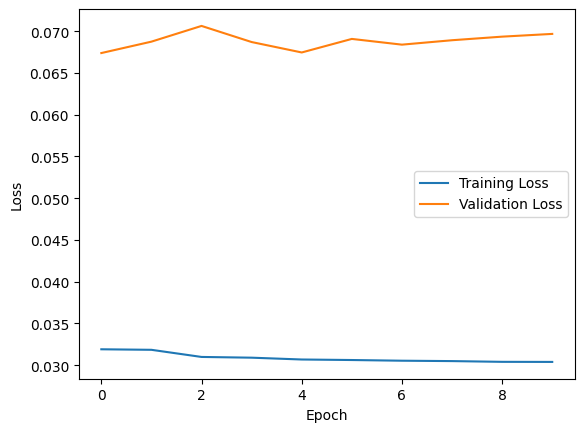

In [6]:
plt.clf()
plt.plot(plot_train_loss, label="Training Loss")
plt.plot(plot_val_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Predictions- and actual consumption

In [7]:
plot_predictions(500, 514, y_test, predicted)

IndexError: index 12000 is out of bounds for dimension 0 with size 11289